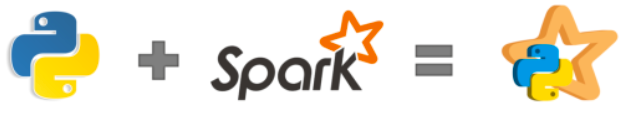

# **PySpark** 
PySpark is use with big data. The primary limit to spark abilities is the level of RAM in the spark clusters.

In this notebook, I used the flight delay dataset to carry out analyses basically using pyspark.

In [1]:
# install pyspark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 kB 13.4 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=d164e3942779cfe007d8284a95b9f89f3486568612f92252c5947761ac8a81ea
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.5
    Uninstalling py4j-0.10.9.5:
      Successfully uninstalled py4j-0.10.9.5


In [2]:
# libraries
import os
import time
import numpy as np
import pandas as pd 

from pyspark.sql import SparkSession
import pyspark.sql.functions as F  #for aggregate e.g(.agg() method)

import warnings
warnings.filterwarnings('ignore')

In [3]:
# to display all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
# create spark session
spark = SparkSession.builder.appName('flight_delay').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/12 07:22:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# file path
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fligths-delays/airports.csv
/kaggle/input/fligths-delays/airlines.csv
/kaggle/input/fligths-delays/flights.csv


Import dataframe file using spark, which we then apply spark method and libraries on for analysis

In [6]:
# load data
file_path = '/kaggle/input/fligths-delays/flights.csv'
file_path1 = '/kaggle/input/fligths-delays/airlines.csv'
file_path2 = '/kaggle/input/fligths-delays/airports.csv'

flights = spark.read.csv(file_path,
                         inferSchema = True,
                         header = True)

airlines = spark.read.csv(file_path1,
                         inferSchema = True,
                         header = True)

airports = spark.read.csv(file_path2,
                         inferSchema = True,
                         header = True)

In [7]:
# display dataframe
flights.show(2)

22/06/12 07:22:30 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+------+----+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR_|MONTH_|DAY_|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|
+-----+------+----+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+-

In [8]:
# display in pandas format
flights.toPandas().head(2)

,YEAR_,MONTH_,DAY_,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,None,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,None,NaN,NaN,NaN,NaN,NaN


To validate the data type in flight dataframe, we will check the schema.

The advantage of having a well defined schema is that it improves import performance.

In [9]:
flights.printSchema()

root
 |-- YEAR_: integer (nullable = true)
 |-- MONTH_: integer (nullable = true)
 |-- DAY_: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (n

Drop null columns from flights and airports  table

In [10]:
flights = flights.drop('AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY')

In [11]:
airports = airports.drop('_c7','_c8','_c9','_c10','_c11','_c12','_c13','_c14','_c15','_c16','_c17','_c18','_c19','_c20','_c21','_c22','_c23','_c24','_c25','_c26','_c27','_c28','_c29', '_c30','_c31','_c32', '_c33','CANCELLATION_REASON', 'AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY')

## Querying SQL in spark

Using spark with sql, you have to first register a sql temporary view using the **.createOrReplaceTempView()** method.


In [12]:
# using spark with sql, first register a sql temporary view
flights.createOrReplaceTempView("flights")

# use spark.sql and query inside it and then return a pandas dataframe
query = "select YEAR_, DESTINATION_AIRPORT, count(DESTINATION_AIRPORT) as dest_count\
         from flights\
         where ORIGIN_AIRPORT = 'SEA'\
         group by 1,2\
         order by 1 desc"

flight_query = spark.sql(query)
flight_query.show(5)

+-----+-------------------+----------+
|YEAR_|DESTINATION_AIRPORT|dest_count|
+-----+-------------------+----------+
| 2015|                JFK|       330|
| 2015|                JNU|       137|
| 2015|                SAT|        68|
| 2015|                PHX|      1217|
| 2015|                MSY|        68|
+-----+-------------------+----------+
only showing top 5 rows



In [13]:
# We can also register multiple temporary views
airlines.createOrReplaceTempView("airlines")
airports.createOrReplaceTempView("airports")

In [14]:
# To check the temporary views created.
spark.catalog.listTables() 

[Table(name='airlines', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='airports', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='flights', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [15]:
# we can also check this way
spark.sql("SHOW views").show()

+---------+--------+-----------+
|namespace|viewName|isTemporary|
+---------+--------+-----------+
|         |airlines|       true|
|         |airports|       true|
|         | flights|       true|
+---------+--------+-----------+



In [16]:
# to create a spark dataframe from the table using spark.table
temp_table = spark.table("flights")
temp_table.show(5)

+-----+------+----+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+
|YEAR_|MONTH_|DAY_|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|
+-----+------+----+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+
| 2015|     1|   1|          4|     AS| 

## Using the parquet format to read data

Reading and writing files in parquet files are perfect for sql queries in spark. Data are imported either in csv, json or other data source format but inorder to process data in a flexible and optimal format in spark, using the parquet format will do just that. The parquet format is a columnar data source that allows spark to use predicate pushdown i.e spark will only process the data necessary to complete the operations define. 


In [17]:
# to save the dataframe in parquet format, remember the inital flight csv dataframe
flight_df = flights.write.parquet('flights.parquet', mode = 'overwrite')

In [18]:
# to read the parquet file into a new dataframe 
flight_df = spark.read.parquet('flights.parquet')
flight_df 

DataFrame[YEAR_: int, MONTH_: int, DAY_: int, DAY_OF_WEEK: int, AIRLINE: string, FLIGHT_NUMBER: int, TAIL_NUMBER: string, ORIGIN_AIRPORT: string, DESTINATION_AIRPORT: string, SCHEDULED_DEPARTURE: int, DEPARTURE_TIME: int, DEPARTURE_DELAY: int, TAXI_OUT: int, WHEELS_OFF: int, SCHEDULED_TIME: int, ELAPSED_TIME: int, AIR_TIME: int, DISTANCE: int, WHEELS_ON: int, TAXI_IN: int, SCHEDULED_ARRIVAL: int, ARRIVAL_TIME: int, ARRIVAL_DELAY: int, DIVERTED: int, CANCELLED: int, CANCELLATION_REASON: string]

In [19]:
# register in temp table
flight_df.createOrReplaceTempView('flights') 

In [20]:
# run sql query on the parquet file to find the distinct count of origin and destination airport 
origin_dest_count = spark.sql('select count(distinct origin_airport) as origin_airport\
                               from flights').collect()[0]
print('Count of origin airport: %d' % origin_dest_count)   

Count of origin airport: 315


## Creating new column

To create a new column in spark from existing column with an additional expression, the **.withColumn()** method is used and to make the changes pemernent, a new variable is assigned.

In [21]:
# add a duration_hrs column
flights = flights.withColumn("duration_hrs", flights.AIR_TIME / 60)

# to view changes
flights.select("duration_hrs").show(5)

+-----------------+
|     duration_hrs|
+-----------------+
|2.816666666666667|
|4.383333333333334|
|4.433333333333334|
|              4.3|
|3.316666666666667|
+-----------------+
only showing top 5 rows



In [22]:
# using the lower function to transform all rows in CANCELLATION_REASON to lowercase
flights = flights.withColumn("cancellation_reasons", F.lower('CANCELLATION_REASON'))
flights.select("cancellation_reasons").show(5)

+--------------------+
|cancellation_reasons|
+--------------------+
|                null|
|                null|
|                null|
|                null|
|                null|
+--------------------+
only showing top 5 rows



## Partitioning : Adding an ID field
Using spark function **F.monotonically_increasing_id()** method to add row id

In [23]:
# creating a row ID with distinct row
flights_df = flights.select(flights["origin_airport"]).distinct()

# count rows in flights_df and number of partition
print('\nThere are %d rows in the flights_df dataframe.\n' % flights_df.count())
print('\nThere are %d partition in the flights_df dataframe.\n' % flights_df.rdd.getNumPartitions())

# add a row ID
flights_df = flights_df.withColumn('row_id', F.monotonically_increasing_id())

# show the highest 10 row
flights_df.orderBy(flights_df.row_id.desc()).show(2)


There are 315 rows in the flights_df dataframe.




There are 1 partition in the flights_df dataframe.



+--------------+------+
|origin_airport|row_id|
+--------------+------+
|           BGR|   314|
|           ITH|   313|
+--------------+------+
only showing top 2 rows



## Filtering data and selecting column

Filtering data in spark is more like the where clause in sql, it filters a subset of row to meet a condition using the **.filter()** method.

Selecting column works exactly like the select in sql, the **.select()** method select only the selected column.

In [24]:
# filter where distance > 2000
long_flight = flights.filter("distance > 2000")
long_flight.show(2)

+-----+------+----+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+-----------------+--------------------+
|YEAR_|MONTH_|DAY_|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|     duration_hrs|cancellation_reasons|
+-----+------+----+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--

In [25]:
# select columns, filter multiple rows and sort
temp = flights.select("origin_airport", 
                      "destination_airport", 
                      "tail_number", 
                      "airline")
filter_temp = temp.filter("origin_airport == 'SEA' and destination_airport == 'PDX'").orderBy("tail_number", ascending = True) 
filter_temp.show(2)

+--------------+-------------------+-----------+-------+
|origin_airport|destination_airport|tail_number|airline|
+--------------+-------------------+-----------+-------+
|           SEA|                PDX|     N161PQ|     OO|
|           SEA|                PDX|     N161PQ|     OO|
+--------------+-------------------+-----------+-------+
only showing top 2 rows



Using the **.selectExpression()** method.

Here **.selectExpression()**  method was able to filter the selected column and create a new column from the exixting column with a new alias name using **as**

In [26]:
# define avg_speed using .selectExpr() method
avg_speed = flights.selectExpr("origin_airport", 
                               "destination_airport", 
                               "tail_number", 
                               "airline", 
                               "round(distance/(air_time/60),2) as avg_speed")
avg_speed.show(5)

+--------------+-------------------+-----------+-------+---------+
|origin_airport|destination_airport|tail_number|airline|avg_speed|
+--------------+-------------------+-----------+-------+---------+
|           ANC|                SEA|     N407AS|     AS|   514.08|
|           LAX|                PBI|     N3KUAA|     AA|   531.56|
|           SFO|                CLT|     N171US|     US|   517.89|
|           LAX|                MIA|     N3HYAA|     AA|   544.65|
|           SEA|                ANC|     N527AS|     AS|   436.58|
+--------------+-------------------+-----------+-------+---------+
only showing top 5 rows



Using the **.contains()** method to filter a given row in a column

In [27]:
# using the .contains() method
flights.filter(flights['airline'].contains('AA')).orderBy(['origin_airport', 'destination_airport'], ascending = [True, True]).show(2)

+-----+------+----+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+------------------+--------------------+
|YEAR_|MONTH_|DAY_|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|      duration_hrs|cancellation_reasons|
+-----+------+----+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+

In [28]:
# using ~(negate)
flights.filter(~ F.col('airline').contains('AA')).show(2)

+-----+------+----+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+-----------------+--------------------+
|YEAR_|MONTH_|DAY_|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|     duration_hrs|cancellation_reasons|
+-----+------+----+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--

**.like()** method to filter the given statement in a column

In [29]:
# using .like()
flights.filter(flights['airline'].like('%A%')).show(2)

+-----+------+----+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+-----------------+--------------------+
|YEAR_|MONTH_|DAY_|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|     duration_hrs|cancellation_reasons|
+-----+------+----+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--

In [30]:
# isin 
flights.filter(flights['origin_airport'].isin(['PDX', 'LAX', 'SEA'])).show(2)

+-----+------+----+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+-----------------+--------------------+
|YEAR_|MONTH_|DAY_|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|     duration_hrs|cancellation_reasons|
+-----+------+----+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--

## Conditional dataframe column operations

**.when(if condition, then x)**

In [31]:
flights.select(flights.ORIGIN_AIRPORT, flights.DESTINATION_AIRPORT, flights.AIRLINE, 
               F.when(flights.AIRLINE == 'OO', "yes").alias("airline_status")).show(5)

+--------------+-------------------+-------+--------------+
|ORIGIN_AIRPORT|DESTINATION_AIRPORT|AIRLINE|airline_status|
+--------------+-------------------+-------+--------------+
|           ANC|                SEA|     AS|          null|
|           LAX|                PBI|     AA|          null|
|           SFO|                CLT|     US|          null|
|           LAX|                MIA|     AA|          null|
|           SEA|                ANC|     AS|          null|
+--------------+-------------------+-------+--------------+
only showing top 5 rows



In [32]:
flights.select(flights.ORIGIN_AIRPORT, flights.DESTINATION_AIRPORT, flights.AIRLINE,
               F.when(flights.AIRLINE == 'OO', "yes")
               .when(flights.AIRLINE != 'OO', "no").alias("airline_status")).show(5)

+--------------+-------------------+-------+--------------+
|ORIGIN_AIRPORT|DESTINATION_AIRPORT|AIRLINE|airline_status|
+--------------+-------------------+-------+--------------+
|           ANC|                SEA|     AS|            no|
|           LAX|                PBI|     AA|            no|
|           SFO|                CLT|     US|            no|
|           LAX|                MIA|     AA|            no|
|           SEA|                ANC|     AS|            no|
+--------------+-------------------+-------+--------------+
only showing top 5 rows



Using the **otherwise()** clause, it is like else 

In [33]:
# using the otherwise() clause
flights.select(flights.ORIGIN_AIRPORT, flights.DESTINATION_AIRPORT, flights.AIRLINE, 
               F.when(flights.AIRLINE == 'OO', "yes")
               .otherwise("no").alias("airline_status")).orderBy("airline_status", ascending = False).show(5)

+--------------+-------------------+-------+--------------+
|ORIGIN_AIRPORT|DESTINATION_AIRPORT|AIRLINE|airline_status|
+--------------+-------------------+-------+--------------+
|           ICT|                MSP|     OO|           yes|
|           SLC|                SGU|     OO|           yes|
|           SLC|                LGB|     OO|           yes|
|           SLC|                SFO|     OO|           yes|
|           SLC|                SJC|     OO|           yes|
+--------------+-------------------+-------+--------------+
only showing top 5 rows



## Grouping and aggregating

Using the aggregation method like **.min(), .max(), .count()** by calling the **.groupby()** dataframe method.

In [34]:
# find the shortest flight from PDX in terms of distance
flights.filter("origin_airport == 'PDX'").groupby().min("distance").show(5)

+-------------+
|min(distance)|
+-------------+
|          129|
+-------------+



In [35]:
# find the longest flight from SEA in terms of distance
flights.filter("origin_airport == 'SEA'").groupby().max("distance").show()

+-------------+
|max(distance)|
+-------------+
|         2724|
+-------------+



In [36]:
# group by origin and find the avg duration of flight
flights.groupby("origin_airport").avg("air_time").show(5)

+--------------+------------------+
|origin_airport|     avg(air_time)|
+--------------+------------------+
|           PSE|188.20689655172413|
|           INL|31.939655172413794|
|           MSY|102.95707304187029|
|           PPG| 308.7142857142857|
|           GEG| 82.17637540453075|
+--------------+------------------+
only showing top 5 rows



In [37]:
# group by origin, destination and find the avg duration of flight
flights.groupby("origin_airport", "destination_airport").avg("air_time").show(5)

+--------------+-------------------+------------------+
|origin_airport|destination_airport|     avg(air_time)|
+--------------+-------------------+------------------+
|           BQN|                MCO|          151.7375|
|           PHL|                MCO| 127.0958605664488|
|           MCI|                IAH|102.25632911392405|
|           SPI|                ORD|38.026595744680854|
|           SNA|                PHX| 53.12903225806452|
+--------------+-------------------+------------------+
only showing top 5 rows



In [38]:
# alternatively
flights.groupby("origin_airport", "destination_airport").agg({"air_time": 'mean'}).show(5)

+--------------+-------------------+------------------+
|origin_airport|destination_airport|     avg(air_time)|
+--------------+-------------------+------------------+
|           BQN|                MCO|          151.7375|
|           PHL|                MCO| 127.0958605664488|
|           MCI|                IAH|102.25632911392405|
|           SPI|                ORD|38.026595744680854|
|           SNA|                PHX| 53.12903225806452|
+--------------+-------------------+------------------+
only showing top 5 rows



## Renaming and joining tables in spark

Renaming a column using .**withColumnRenamed()** method and the **.join()** method to join tables using column that are both common to each table.

In [39]:
# rename IATA_CODE column in airports table to airport_code
airports = airports.withColumnRenamed("IATA_CODE", "origin_airport")

In [40]:
# join flights dataframe to airports dataframe
flight_airports = flights.join(airports,\
                          flights["ORIGIN_AIRPORT"] == airports["origin_airport"])
flight_airports.show(2)

+-----+------+----+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+-----------------+--------------------+--------------+--------------------+-----------+-----+-------+--------+----------+
|YEAR_|MONTH_|DAY_|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|     duration_hrs|cancellation_reasons|origin_airport|             AIRPORT|       CITY|STATE|COUNTRY|LATITUDE| LONGITUDE|
+-----+------+----+-----------+-------+-------------+-----------+--------------+-------------------+------------------

In [41]:
# rename IATA_CODE column in airports table to airline
airlines = airlines.withColumnRenamed("IATA_CODE", "airline")

# join flight_airports dataframe to airports dataframe
flight_airports_airlines = flight_airports.join(airlines, on = "airline", how = "leftouter")
print(flight_airports_airlines.show(2))

+-------+-----+------+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+-----------------+--------------------+--------------+--------------------+-----------+-----+-------+--------+----------+--------------------+
|AIRLINE|YEAR_|MONTH_|DAY_|DAY_OF_WEEK|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|     duration_hrs|cancellation_reasons|origin_airport|             AIRPORT|       CITY|STATE|COUNTRY|LATITUDE| LONGITUDE|             AIRLINE|
+-------+-----+------+----+-----------+-------------+-----------+-----------

## Caching
This improves performance when reusing a dataframe.

In [42]:
start_time = time.time()

# add caching to the rows in flights_df
flights_df = flights_df.distinct().cache()
#  count rows in flights_df noting the time
print("Counting %d rows took %f seconds" % (flights_df.count(), time.time() - start_time))


start_time = time.time()
#  count rows in flights_df again, noting the time
print("Counting %d rows took %f seconds" % (flights_df.count(), time.time() - start_time))

Counting 315 rows took 3.363974 seconds
Counting 315 rows took 0.905924 seconds


In [43]:
# to check if a dataframe is cached
print('Is flights_df cached? : %s' % flights_df.is_cached)

Is flights_df cached? : True


In [44]:
# to remove a cached dataframe 
flights_df.unpersist()

print('Is flights_df cached? : %s' % flights_df.is_cached)

Is flights_df cached? : False


Data pipeline within spark consist of the;

input: csv, JSON and other databases

transformation: withColumn(), drop(), filter(), select() 

output:csv, parquet, database

validation

analysis

**Reasources**: Datacamp

# Feel free to drop your suggestion, I will appreciate it.
